## Introduction 

In [14]:
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import numpy as np
import pandas as pd
import datetime as dt
import pylab
from matplotlib import pyplot as plt
%matplotlib inline
import scipy as sc
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings(action="ignore")


In [18]:
fifa = pd.read_csv('2019fifadata.csv')
fifa = pd.DataFrame(fifa)
print(fifa.columns)
print(fifa.info())
fifa.head()

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club  ... Composure Marking StandingTackle  SlidingTackle  \
0         FC Barcelona  ...      96.0    33.0           28.0           26.0   
1             Juventus  ...      95.0    28.0           31.0           23.0   
2  Paris Saint-Germain  ...      94.0    27.0           24.0           33.0   
3    Manchester United  ...      68.0    15.0           21.0           13.0   
4      Manchester City  ...      88.0    68.0           58.0           51.0   

  GKDiving  GKHandling  GKKicking  GKPositioning GKReflexes Release Clause  
0      6.0        11.0       15.0           14.0        8.0        €226.5M  
1      7.0        11.0       15.0           14.0       11.0        €127.1M  
2      9.0         9.0       15.0           15.0       11.0        €228.1M  
3     90.0        85.0       87.0           88.0       94.0        €138.6M  
4     15.0        13.0        5.0           10.0       13.0        €196.4M  

[5 rows x 89 columns]

We'll look at how to predict a player's wage. I'll remove columns that don't provide useful information (Unnamed:0, ID, Name, Photo, Flag, Club Logo, Real Face, Joined, Jersey Number, Loaned From, and Release Clause). As we have 18,207 entries and multiple columns are missing 48 values, my instinct is that these rows are missing information in these columns. As such, I'll remove rows missing information in 48 cell. Additionally, I'm going to remove all columns from LS through RB for two reasons: the first being that they're all missing values in over two thousand cells and the second being that it's not clear what each variable represents (there's no information on the Kaggle page and it's not immediately clear on the sofifa.com page). There are still quite a few variables, so we should be able to come up with a good model.

After these updates, we're still missing values in Club, Contract Valid Until, and Position columns. While I could go through and find the information on each of these, I don't think that would be a great use of time for this project, so I'm going to drop rows for which there aren't values for Club/Contract valid until and hope this takes care of rows lacking a value in Position as well. Finally, Club is a categorical variable with over 650 categories, which will be a pain to create/utilize dummies for, so I will remove this column.

We've managed to clean up our data and keep over 98% of the rows. If we have trouble coming up with a model, we'll look at adding back some columns we've removed.

In [19]:
fifa = fifa.dropna(thresh=48, axis=0)
# fifa = fifa.drop(['Unnamed: 0', 'ID', 'Name', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Joined', 'Jersey Number', 
#                   'Loaned From','LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW','LAM', 'CAM', 'RAM', 'LM', 'LCM', 
#                   'CM', 'RCM', 'RM', 'LWB', 'LDM','CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 
#                   'Release Clause'], axis=1)
fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18159 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18159 non-null int64
ID                          18159 non-null int64
Name                        18159 non-null object
Age                         18159 non-null int64
Photo                       18159 non-null object
Nationality                 18159 non-null object
Flag                        18159 non-null object
Overall                     18159 non-null int64
Potential                   18159 non-null int64
Club                        17918 non-null object
Club Logo                   18159 non-null object
Value                       18159 non-null object
Wage                        18159 non-null object
Special                     18159 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [4]:
fifa = fifa[pd.notnull(fifa['Position'])]
fifa = fifa.drop(['Club', 'Contract Valid Until'], axis=1)
fifa.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18147 entries, 0 to 18206
Data columns (total 50 columns):
Age                         18147 non-null int64
Nationality                 18147 non-null object
Overall                     18147 non-null int64
Potential                   18147 non-null int64
Value                       18147 non-null object
Wage                        18147 non-null object
Special                     18147 non-null int64
Preferred Foot              18147 non-null object
International Reputation    18147 non-null float64
Weak Foot                   18147 non-null float64
Skill Moves                 18147 non-null float64
Work Rate                   18147 non-null object
Body Type                   18147 non-null object
Position                    18147 non-null object
Height                      18147 non-null object
Weight                      18147 non-null object
Crossing                    18147 non-null float64
Finishing                   18147 non-nul

Transform Variables**

There are quite a few columns that are currently being reated as objects but should be integers or floats. I'll remove the €, K, and M from the Wage and Value columns and update the values as necessary. I will update the Height column into inches and remove the lbs from the Weight column. I'll perform one hot encoding on the remaining values (Nationality, Preferred Foot Work Rate, Body Type, and Position) to obtain dummies.

In [20]:
# fifa['Value'] = fifa['Value'].str.replace('€', '')
# fifa['Value'] = fifa['Value'].str.replace('M', '000000').astype(float)
# fifa['Value'] = fifa['Value'].str.replace('K', '000').astype(float)
# fifa['Wage'] = fifa['Wage'].str.replace('€', '')
# fifa['Wage'] = fifa['Wage'].str.replace('M', '000000').astype(float)
# fifa['Wage'] = fifa['Wage'].str.replace('K', '000').astype(float)

fifa['Value'] = fifa['Value'].str.replace('€', '')
fifa['Value'] = fifa['Value'].apply(lambda row: row.replace('K', '000') if 'K' in row else row.replace('M', '000000')).astype(float)

fifa['Wage'] = fifa['Wage'].str.replace('€', '')
fifa['Wage'] = fifa['Wage'].apply(lambda row: row.replace('K', '000') if 'K' in row else row.replace('M', '000000')).astype(float)

In [21]:
def parse_ht(ht):
    # format: 7' 0.0"
    feet = float(ht[0])
    inches = float(ht[2:])
    return 12*feet + inches


fifa['Height'] = fifa['Height'].apply(lambda x: parse_ht(x))


In [44]:
# fifa['Weight'] = fifa['Weight'].str.split('l')[0]
fifa['Weight'] = fifa['Weight'].apply(lambda x: float(str(x).replace('lbs', '')))

In [45]:
fifa.head()

Age Nationality  Overall  Potential        Value      Wage  Special  \
0   31   Argentina       94         94        110.5  565000.0     2202   
1   33    Portugal       94         94   77000000.0  405000.0     2228   
2   26      Brazil       92         93        118.5  290000.0     2143   
3   27       Spain       91         93   72000000.0  260000.0     1471   
4   27     Belgium       91         92  102000000.0  355000.0     2281   

  Preferred Foot  International Reputation  Weak Foot  ...  Penalties  \
0           Left                       5.0        4.0  ...       75.0   
1          Right                       5.0        4.0  ...       85.0   
2          Right                       5.0        5.0  ...       81.0   
3          Right                       4.0        3.0  ...       40.0   
4          Right                       4.0        5.0  ...       79.0   

  Composure Marking StandingTackle  SlidingTackle  GKDiving  GKHandling  \
0      96.0    33.0           28.0           26.0       6.0        11.0   
1      95.0    28.0           31.0           23.0       7.0        11.0   
2      94.0    27.0           24.0           33.0       9.0         9.0   
3      68.0    15.0           21.0           13.0      90.0        85.0   
4      88.0    68.0           58.0           51.0      15.0        13.0   

   GKKicking  GKPositioning  GKReflexes  
0       15.0           14.0         8.0  
1       15.0           14.0        11.0  
2       15.0           15.0        11.0  
3       87.0           88.0        94.0  
4        5.0           10.0        13.0  

[5 rows x 50 columns]

In [22]:
fifa = pd.concat([fifa, pd.get_dummies(fifa['Nationality'])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Preferred Foot"])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Work Rate"])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Body Type"])], axis=1)
fifa = pd.concat([fifa, pd.get_dummies(fifa["Position"])], axis=1)

# fifa.head()

In [23]:
corr_mat = np.abs((fifa.corr().loc[:, ['Wage']])).sort_values(by='Wage', ascending=False)
corr_mat[:50]

Wage
Wage                      1.000000
International Reputation  0.668635
Value                     0.603267
Overall                   0.571720
Reactions                 0.495560
Potential                 0.486604
Unnamed: 0                0.479437
Composure                 0.419597
Special                   0.347878
Vision                    0.315395
ShortPassing              0.296691
BallControl               0.277615
LongPassing               0.276762
Skill Moves               0.263205
Curve                     0.259550
ShotPower                 0.258351
Volleys                   0.257357
LongShots                 0.249084
Dribbling                 0.237150
FKAccuracy                0.236385
Crossing                  0.232834
Positioning               0.226775
Penalties                 0.222440
Finishing                 0.217439
ID                        0.204653
Aggression                0.194581
HeadingAccuracy           0.187967
Messi                     0.187094
Stamina                   0.177562
Interceptions             0.157415
Agility                   0.156287
Marking                   0.145594
Age                       0.141306
Weak Foot                 0.140849
Strength                  0.139360
C. Ronaldo                0.133181
Medium/ Medium            0.131849
SprintSpeed               0.130315
Jumping                   0.129691
High/ High                0.127908
StandingTackle            0.126291
Acceleration              0.124985
SlidingTackle             0.111025
Neymar                    0.094431
Balance                   0.088873
Jersey Number             0.086561
PLAYER_BODY_TYPE_25       0.082638
Brazil                    0.079908
Courtois                  0.077583
Spain                     0.074848

In [25]:
# fifa = pd.get_dummies(fifa)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
fifa.corr()

Unnamed: 0        ID       Age   Overall  Potential  \
Unnamed: 0                  1.000000  0.416108 -0.455707 -0.972796  -0.633444   
ID                          0.416108  1.000000 -0.739162 -0.417354   0.046577   
Age                        -0.455707 -0.739162  1.000000  0.453069  -0.252281   
Overall                    -0.972796 -0.417354  0.453069  1.000000   0.661180   
Potential                  -0.633444  0.046577 -0.252281  0.661180   1.000000   
Value                      -0.302997 -0.090425  0.048319  0.394666   0.364335   
Wage                       -0.479437 -0.204653  0.141306  0.571720   0.486604   
Special                    -0.596913 -0.231366  0.236875  0.607236   0.384598   
International Reputation   -0.413322 -0.356191  0.253765  0.499491   0.372993   
Weak Foot                  -0.204026 -0.075784  0.059867  0.212015   0.162346   
Skill Moves                -0.415672 -0.056914  0.027649  0.414463   0.354290   
Jersey Number               0.213645  0.182074 -0.241156 -0.218931  -0.010474   
Height                     -0.034734 -0.090199  0.082604  0.038546  -0.009807   
Crossing                   -0.390062 -0.131994  0.130545  0.394972   0.246319   
Finishing                  -0.325529 -0.082323  0.068660  0.332515   0.243355   
HeadingAccuracy            -0.337766 -0.106815  0.147183  0.340776   0.200988   
ShortPassing               -0.492495 -0.136279  0.132894  0.502550   0.369189   
Volleys                    -0.384285 -0.159915  0.142472  0.391338   0.254906   
Dribbling                  -0.364106 -0.030340  0.010166  0.372426   0.315019   
Curve                      -0.416378 -0.169511  0.143276  0.419491   0.279944   
FKAccuracy                 -0.395433 -0.199549  0.193467  0.396892   0.230544   
LongPassing                -0.477500 -0.186764  0.181310  0.483909   0.321437   
BallControl                -0.449655 -0.100184  0.084969  0.460197   0.354396   
Acceleration               -0.185030  0.133236 -0.158667  0.196869   0.234608   
SprintSpeed                -0.198797  0.132437 -0.151682  0.210647   0.236771   
Agility                    -0.256270 -0.019897 -0.019395  0.264952   0.222310   
Reactions                  -0.832156 -0.408617  0.453124  0.850045   0.513425   
Balance                    -0.097160  0.048463 -0.089877  0.103160   0.138025   
ShotPower                  -0.440023 -0.166133  0.156947  0.441118   0.288318   
Jumping                    -0.261581 -0.169369  0.177167  0.264435   0.109151   
Stamina                    -0.358451 -0.053895  0.097793  0.365656   0.202563   
Strength                   -0.342839 -0.259756  0.332798  0.349326   0.075769   
LongShots                  -0.417853 -0.161549  0.155096  0.420795   0.266740   
Aggression                 -0.397067 -0.228329  0.265190  0.395470   0.171174   
Interceptions              -0.319162 -0.160602  0.197845  0.321326   0.154908   
Positioning                -0.351820 -0.088330  0.082443  0.356493   0.245616   
Vision                     -0.490296 -0.215170  0.187422  0.498894   0.348141   
Penalties                  -0.337899 -0.140657  0.139535  0.341429   0.224281   
Composure                  -0.716173 -0.384473  0.391023  0.727655   0.440008   
Marking                    -0.280829 -0.110198  0.142817  0.286505   0.162801   
StandingTackle             -0.248564 -0.085929  0.119745  0.252629   0.143564   
SlidingTackle              -0.220034 -0.068409  0.103089  0.222811   0.128980   
GKDiving                    0.027757 -0.105594  0.101277 -0.025937  -0.053446   
GKHandling                  0.027026 -0.111149  0.106419 -0.025062  -0.054672   
GKKicking                   0.030654 -0.106652  0.104964 -0.029372  -0.059061   
GKPositioning               0.019842 -0.118250  0.116402 -0.017674  -0.052589   
GKReflexes                  0.025610 -0.105778  0.103313 -0.023276  -0.053341   
Afghanistan                 0.014801  0.010136 -0.008335 -0.011270  -0.008636   
Albania                     0.000571  0.011315 -0.010386 

After a look at the correlation matrix with our updated values and dummies, the variables with the highest correlations are Overall (.57), Potential (.48), Value (.60), International Reputation (.66), Reactions (.49), and  Composure (.41).

As we can see in the boxenplots, four of the variables have a relatively normal distribution and all have outliers. I will winsorize Overall, Reactions, and Composure, and square root Wage, Value, and Potential. I worry that if I apply any transformation on International Reputation, I'll lose information on the data so I'll leave that for now. Additionally, I will normalize everything.

In [48]:
# fifa.reset_index(inplace=1)

In [28]:
fifa.Wage = fifa.Wage.replace(0, 0.1)
fifa.Value = fifa.Value.replace(0, 0.1)

In [34]:
# Dealing with outliers and normalizing our features and target

winsorized_Wage = winsorize(fifa['Wage'], (0, 0.10))
log_Wage = np.log(fifa['Wage'])
fifa["sqrt_Wage"] = sqrt_Wage = np.sqrt(fifa['Wage'])
bc_Wage,_ = boxcox(fifa['Wage'])#power_transform(np.array(fifa["Wage"]).reshape(1,-1)).reshape(-1,1)
fifa["norm_sqrt_Wage"] = normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

fifa["winsorized_Overall"] = winsorized_Overall = winsorize(fifa['Overall'], (0, 0.10))
log_Overall = np.log(fifa['Overall'])
sqrt_Overall = np.sqrt(fifa['Overall'])
bc_Overall,_ = boxcox(fifa['Overall'])
fifa["norm_winsorized_Overall"] = normalize(np.array(fifa["winsorized_Overall"]).reshape(1,-1)).reshape(-1,1)

winsorized_Potential = winsorize(fifa['Potential'], (0, 0.10))
log_Potential = np.log(fifa['Potential'])
fifa["sqrt_Potential"] = sqrt_Potential = np.sqrt(fifa['Potential'])
bc_Potential,_ = boxcox(fifa['Potential'])
fifa["norm_sqrt_Potential"] = normalize(np.array(fifa["sqrt_Potential"]).reshape(1,-1)).reshape(-1,1)

winsorized_Value = winsorize(fifa['Value'], (0, 0.10))
log_Value = np.log(fifa['Value'])
fifa["sqrt_Value"] = sqrt_Value = np.sqrt(fifa['Value'])
bc_Value,_ = boxcox(fifa['Value'])
fifa["norm_sqrt_Value"] = normalize(np.array(fifa["sqrt_Value"]).reshape(1,-1)).reshape(-1,1)

winsorized_International_Reputation = pd.Series(winsorize(fifa['International Reputation'], (0, 0.10)))
log_International_Reputation = np.log(fifa['International Reputation'])
fifa['sqrt_International_Reputation'] = np.sqrt(fifa['International Reputation'])
bc_International_Reputation,_ = boxcox(fifa['International Reputation'])
fifa['norm_sqrt_International_Reputation'] = normalize(np.array(fifa["sqrt_International_Reputation"]).reshape(-1, 1)).reshape(-1,1)

fifa['winsorized_Reactions'] =  winsorize(fifa['Reactions'], (0, 0.10))
log_Reactions = np.log(fifa['Reactions'])
sqrt_Reactions = np.sqrt(fifa['Reactions'])
bc_Reactions,_ = boxcox(fifa['Reactions'])
fifa["norm_winsorized_Reactions"] = normalize(np.array(fifa["winsorized_Reactions"]).reshape(1,-1)).reshape(-1,1)

fifa['winsorized_Composure'] = winsorized_Composure = winsorize(fifa['Composure'], (0, 0.10))
log_Composure = np.log(fifa['Composure'])
sqrt_Composure = np.sqrt(fifa['Composure'])
bc_Composure,_ = boxcox(fifa['Composure'])
fifa["norm_winsorized_Composure"] = normalize(np.array(fifa["winsorized_Composure"]).reshape(1,-1)).reshape(-1,1)

In [51]:
print(winsorize(fifa['International Reputation']))
fifa.Wage.describe()
fifa.Value.describe()

[5. 5. 5. ... 1. 1. 1.]


count    1.814700e+04
mean     1.167039e+06
std      4.272484e+06
min      1.000000e-01
25%      7.500000e+00
50%      2.700000e+05
75%      6.250000e+05
max      1.020000e+08
Name: Value, dtype: float64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

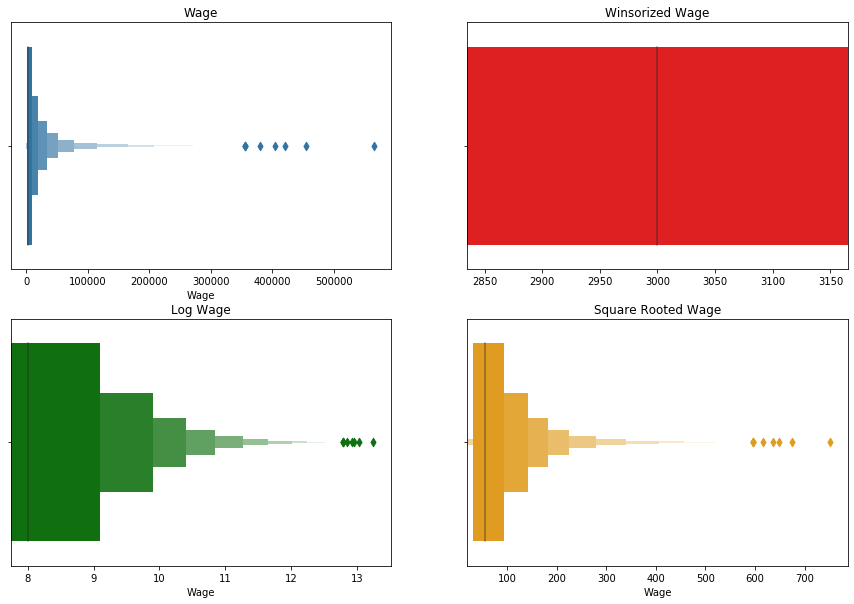

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


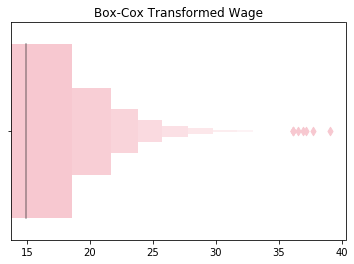

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

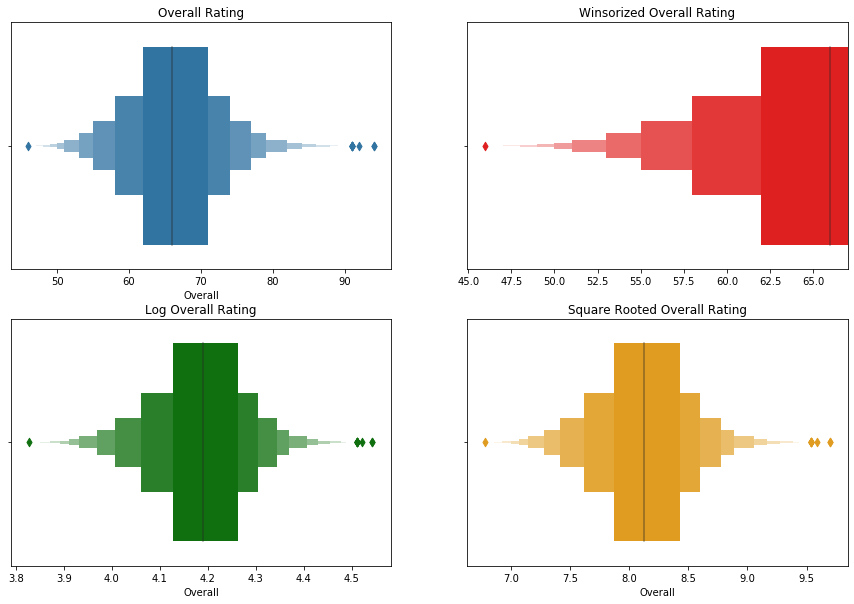

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


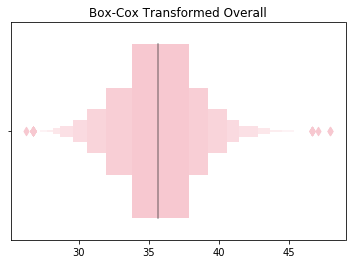

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

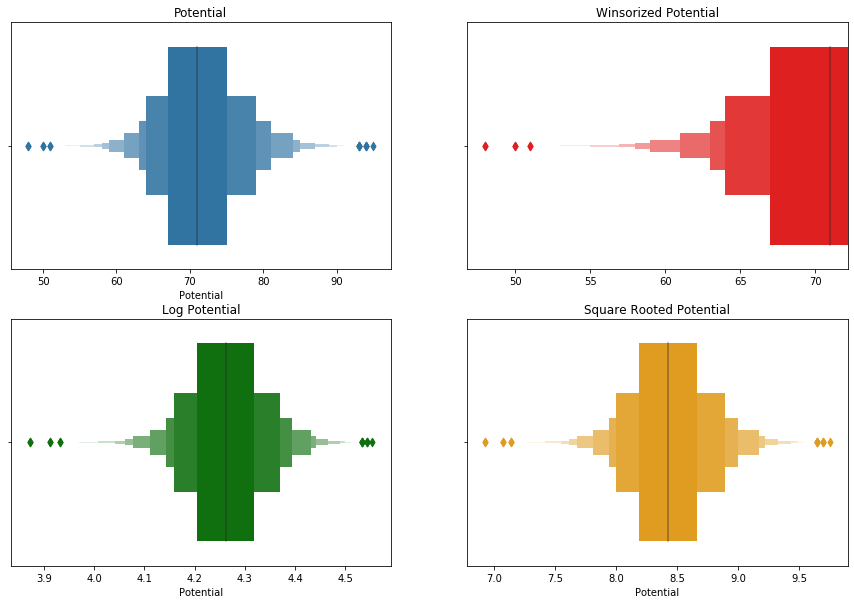

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


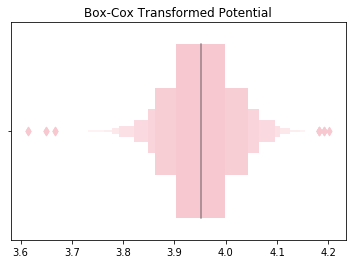

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

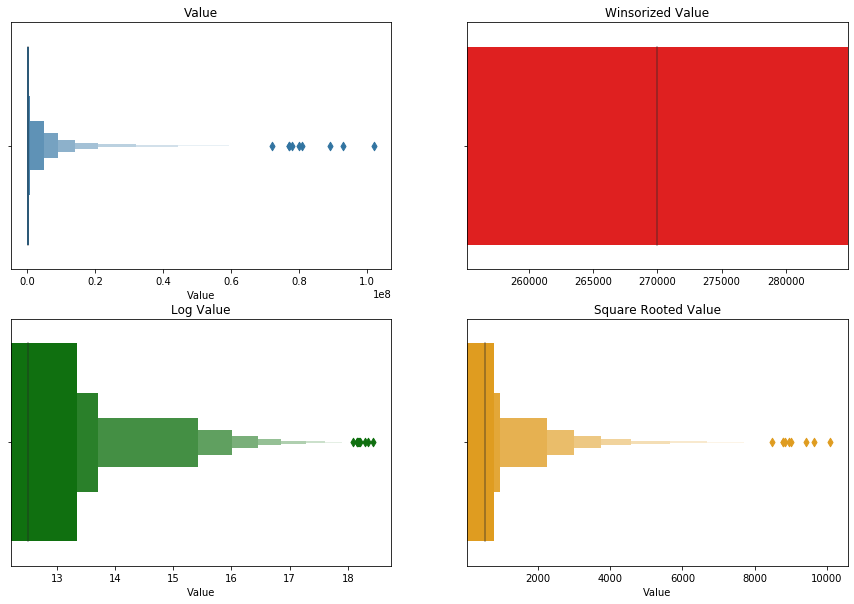

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


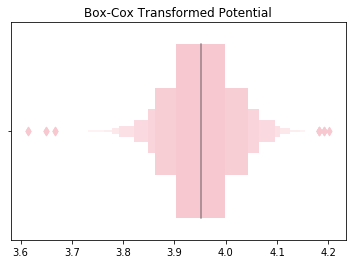

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

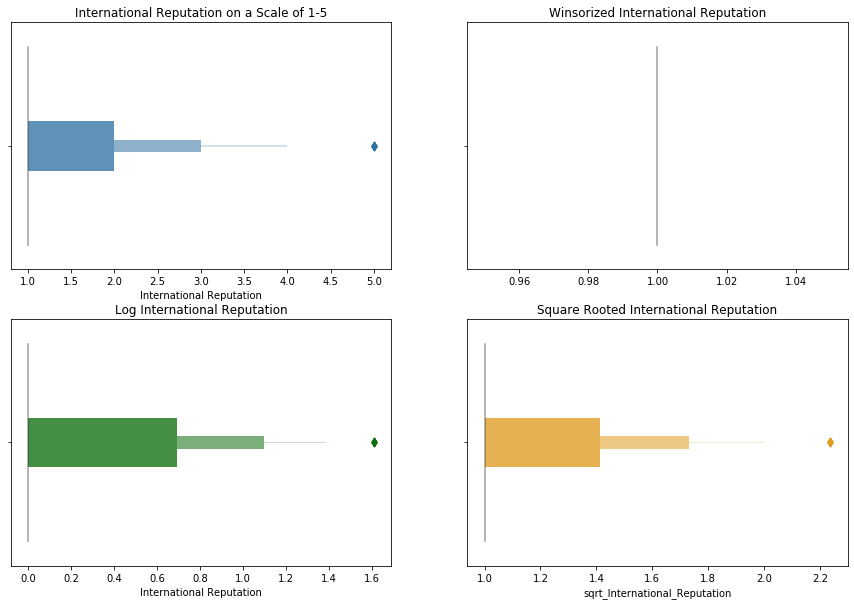

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


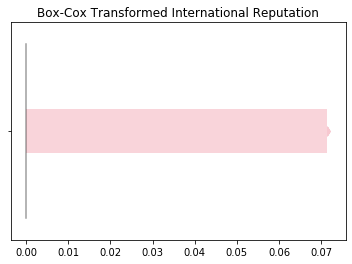

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

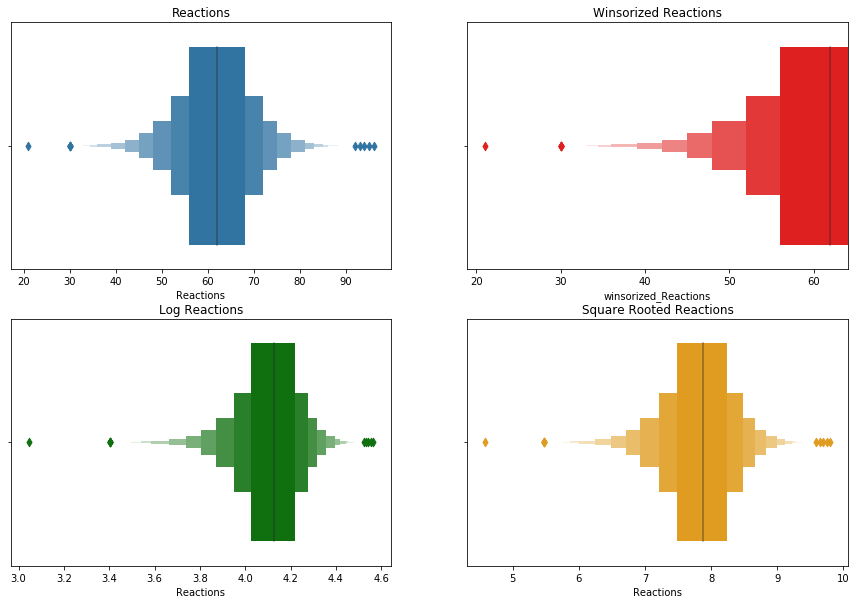

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


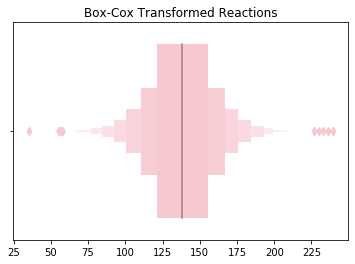

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

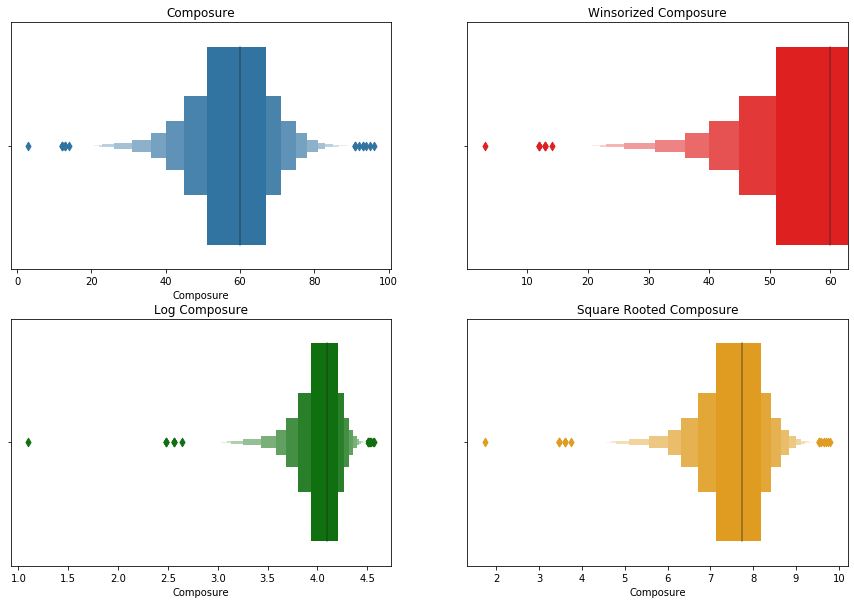

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


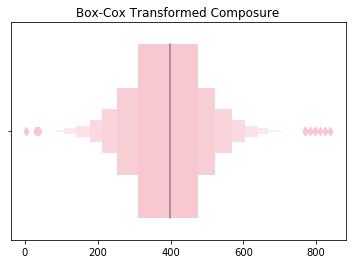

In [37]:
# Visualizing the distribution of our features
plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(x='Wage', data=fifa)
plt.title('Wage')
plt.subplot(2, 2, 2)
sns.boxenplot(winsorized_Wage, color='red')
plt.title('Winsorized Wage')
plt.subplot(2, 2, 3)
sns.boxenplot(log_Wage, color='green')
plt.title('Log Wage')
plt.subplot(2, 2, 4)
sns.boxenplot(sqrt_Wage, color='orange')
plt.title('Square Rooted Wage')
plt.show()
sns.boxenplot(bc_Wage, color='pink')
plt.title('Box-Cox Transformed Wage')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(x='Overall', data=fifa)
plt.title('Overall Rating')
plt.subplot(2, 2, 2)
sns.boxenplot(winsorize(fifa["winsorized_Overall"], [0,.10]), color='red')
plt.title('Winsorized Overall Rating')
plt.subplot(2, 2, 3)
sns.boxenplot(log_Overall, color='green')
plt.title('Log Overall Rating')
plt.subplot(2, 2, 4)
sns.boxenplot(sqrt_Overall, color='orange')
plt.title('Square Rooted Overall Rating')
plt.show()
sns.boxenplot(bc_Overall, color='pink')
plt.title('Box-Cox Transformed Overall')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(fifa['Potential'])
plt.title('Potential')
plt.subplot(2, 2, 2)
sns.boxenplot(winsorized_Potential, color='red')
plt.title('Winsorized Potential')
plt.subplot(2, 2, 3)
sns.boxenplot(log_Potential, color='green')
plt.title('Log Potential')
plt.subplot(2, 2, 4)
sns.boxenplot(sqrt_Potential, color='orange')
plt.title('Square Rooted Potential')
plt.show()
sns.boxenplot(bc_Potential, color='pink')
plt.title('Box-Cox Transformed Potential')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(fifa['Value'])
plt.title('Value')
plt.subplot(2, 2, 2)
sns.boxenplot(winsorized_Value, color='red')
plt.title('Winsorized Value')
plt.subplot(2, 2, 3)
sns.boxenplot(log_Value, color='green')
plt.title('Log Value')
plt.subplot(2, 2, 4)
sns.boxenplot(sqrt_Value, color='orange')
plt.title('Square Rooted Value')
plt.show()
sns.boxenplot(bc_Potential, color='pink')
plt.title('Box-Cox Transformed Potential')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(fifa['International Reputation'])
plt.title('International Reputation on a Scale of 1-5')
plt.subplot(2, 2, 2)
sns.boxenplot(winsorized_International_Reputation, color='red')
plt.title('Winsorized International Reputation')
plt.subplot(2, 2, 3)
sns.boxenplot(log_International_Reputation, color='green')
plt.title('Log International Reputation')
plt.subplot(2, 2, 4)
sns.boxenplot(fifa['sqrt_International_Reputation'], color='orange')
plt.title('Square Rooted International Reputation')
plt.show()
sns.boxenplot(bc_International_Reputation, color='pink')
plt.title('Box-Cox Transformed International Reputation')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(fifa['Reactions'])
plt.title('Reactions')
plt.subplot(2, 2, 2)
sns.boxenplot(fifa['winsorized_Reactions'], color='red')
plt.title('Winsorized Reactions')
plt.subplot(2, 2, 3)
sns.boxenplot(log_Reactions, color='green')
plt.title('Log Reactions')
plt.subplot(2, 2, 4)
sns.boxenplot(sqrt_Reactions, color='orange')
plt.title('Square Rooted Reactions')
plt.show()
sns.boxenplot(bc_Reactions, color='pink')
plt.title('Box-Cox Transformed Reactions')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxenplot(fifa['Composure'])
plt.title('Composure')
plt.subplot(2, 2, 2)
sns.boxenplot(winsorized_Composure, color='red')
plt.title('Winsorized Composure')
plt.subplot(2, 2, 3)
sns.boxenplot(log_Composure, color='green')
plt.title('Log Composure')
plt.subplot(2, 2, 4)
sns.boxenplot(sqrt_Composure, color='orange')
plt.title('Square Rooted Composure')
plt.show()
sns.boxenplot(bc_Composure, color='pink')
plt.title('Box-Cox Transformed Composure')
plt.show()

In [54]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# fifa.corr()

In [38]:
# Testing Normality

jb_stats = stats.jarque_bera(fifa["norm_sqrt_Wage"])
norm_stats = stats.normaltest(fifa["norm_sqrt_Wage"])

print("Jarque-Bera test statistics for normalized Wage is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized Wage is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = stats.jarque_bera(fifa["norm_winsorized_Overall"])
norm_stats = stats.normaltest(fifa["norm_winsorized_Overall"])

print("Jarque-Bera test statistics for normalized Overall is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized Overall is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = stats.jarque_bera(fifa["norm_sqrt_Potential"])
norm_stats = stats.normaltest(fifa["norm_sqrt_Potential"])

print("Jarque-Bera test statistics for normalized Potential is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized Potential is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = stats.jarque_bera(fifa["norm_sqrt_Value"])
norm_stats = stats.normaltest(fifa["norm_sqrt_Value"])

print("Jarque-Bera test statistics for normalized Value is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized Value is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = stats.jarque_bera(fifa["norm_sqrt_International_Reputation"])
norm_stats = stats.normaltest(fifa["norm_sqrt_International_Reputation"])

print("Jarque-Bera test statistics for normalized International Reputation is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized International Reputation is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = stats.jarque_bera(fifa["norm_winsorized_Reactions"])
norm_stats = stats.normaltest(fifa["norm_winsorized_Reactions"])

print("Jarque-Bera test statistics for normalized Reactions is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized Reactions is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = stats.jarque_bera(fifa["norm_winsorized_Composure"])
norm_stats = stats.normaltest(fifa["norm_winsorized_Composure"])

print("Jarque-Bera test statistics for normalized Composure is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics for normalized Composure is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics for normalized Wage is 117614.57144486847 and p value is 0.0
Normality test statistics for normalized Wage is 10678.936221881515 and p value is 0.0
Jarque-Bera test statistics for normalized Overall is 632.2458430649979 and p value is 0.0
Normality test statistics for normalized Overall is 680.2464800202929 and p value is 1.933542384538441e-148
Jarque-Bera test statistics for normalized Potential is 57.618179446179695 and p value is 3.078648447285559e-13
Normality test statistics for normalized Potential is 57.124435255184935 and p value is 3.9408190457195807e-13
Jarque-Bera test statistics for normalized Value is 276087.3472204191 and p value is 0.0
Normality test statistics for normalized Value is 13672.321902913893 and p value is 0.0
Jarque-Bera test statistics for normalized International Reputation is nan and p value is nan
Normality test statistics for normalized International Reputation is 45239.57068558348 and p value is 0.0
Jarque-Bera test statisti

In [56]:
corr_matrix = fifa.corr()
corr_matrix.iloc[-25:, -25:]

Vision  Penalties  Composure   Marking  \
Vision                              1.000000   0.633099   0.636231  0.176873   
Penalties                           0.633099   1.000000   0.552013  0.152547   
Composure                           0.636231   0.552013   1.000000  0.384209   
Marking                             0.176873   0.152547   0.384209  1.000000   
StandingTackle                      0.146433   0.102067   0.351682  0.906529   
SlidingTackle                       0.113176   0.066834   0.317445  0.895890   
GKDiving                           -0.381978  -0.620120  -0.378916 -0.551214   
GKHandling                         -0.377955  -0.618993  -0.375903 -0.552484   
GKKicking                          -0.374843  -0.614028  -0.375104 -0.549652   
GKPositioning                      -0.375857  -0.617090  -0.370397 -0.546885   
GKReflexes                         -0.381223  -0.619109  -0.377768 -0.551524   
sqrt_Wage                           0.408252   0.294336   0.550465  0.197310   
norm_sqrt_Wage                      0.408252   0.294336   0.550465  0.197310   
winsorized_Overall                  0.486572   0.338189   0.718105  0.289355   
norm_winsorized_Overall             0.486572   0.338189   0.718105  0.289355   
sqrt_Potential                      0.346532   0.225215   0.439001  0.163080   
norm_sqrt_Potential                 0.346532   0.225215   0.439001  0.163080   
sqrt_Value                          0.171308   0.116669   0.220755  0.073719   
norm_sqrt_Value                     0.171308   0.116669   0.220755  0.073719   
sqrt_International_Reputation       0.287806   0.221287   0.398511  0.119529   
norm_sqrt_International_Reputation       NaN        NaN        NaN       NaN   
winsorized_Reactions                0.486739   0.336018   0.669180  0.284217   
norm_winsorized_Reactions           0.486739   0.336018   0.669180  0.284217   
winsorized_Composure                0.623615   0.543873   0.990217  0.387665   
norm_winsorized_Composure           0.623615   0.543873   0.990217  0.387665   

                                    StandingTackle  SlidingTackle  GKDiving  \
Vision                                    0.146433       0.113176 -0.381978   
Penalties                                 0.102067       0.066834 -0.620120   
Composure                                 0.351682       0.317445 -0.378916   
Marking                                   0.906529       0.895890 -0.551214   
StandingTackle                            1.000000       0.974658 -0.531141   
SlidingTackle                             0.974658       1.000000 -0.509512   
GKDiving                                 -0.531141      -0.509512  1.000000   
GKHandling                               -0.532298      -0.510749  0.970283   
GKKicking                                -0.531196      -0.509493  0.965704   
GKPositioning                            -0.527935      -0.505941  0.969879   
GKReflexes                               -0.531605      -0.509565  0.973327   
sqrt_Wage                                 0.175406       0.154841 -0.044028   
norm_sqrt_Wage                            0.175406       0.154841 -0.044028   
winsorized_Overall                        0.257213       0.227376 -0.035008   
norm_winsorized_Overall                   0.257213       0.227376 -0.035008   
sqrt_Potential                            0.144223       0.129579 -0.054663   
norm_sqrt_Potential                       0.144223       0.129579 -0.054663   
sqrt_Value                                0.061048       0.051574 -0.016016   
norm_sqrt_Value                           0.061048       0.051574 -0.016016   
sqrt_International_Reputation             0.097208       0.083099  0.003711   
norm_sqrt_International_Reputation             NaN            NaN       NaN   
winsorized_Reactions                      0.257600       0.231304 -0.065728   
norm_winsorized_Reactions                 0.257600       0.231304 -0.065728   
winsorized_Composure                      0.355855       0.32

## First Model

This model is clearly terrible. I'm concerned because these variables were highly correlated with the feature. Perhaps I didn't use enough variables, so I'll add some new variables to see if we can make it any better.

In [57]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = fifa['norm_sqrt_Wage']
X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions",
        "norm_winsorized_Composure", 'norm_sqrt_International_Reputation']]
# X = pd.get_dummies(X)
# X = X.dropna(axis=1)

# rfr.fit(X, Y)
cross_val_score(rfr, X, Y, cv=10)

array([-0.4383148 , -0.02737909, -0.0504407 ,  0.11854584, -0.10043755,
        0.03258632,  0.03392337, -0.0426906 ,  0.0213506 , -0.13217134])

In [ ]:
print(rfr.feature_importances_)

In [56]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfr = ensemble.RandomForestRegressor()
Y = fifa['norm_sqrt_Wage']
X = fifa[["norm_winsorized_Overall", "norm_winsorized_Reactions"]]#, "norm_sqrt_Potential", "norm_sqrt_Value", "norm_International Reputation", "norm_winsorized_Overall", "norm_winsorized_Reactions", "norm_winsorized_Composure"]]
# X = pd.get_dummies(X)
# X = X.dropna(axis=1)

rfr.fit(X, Y)
print(cross_val_score(rfr, X, Y, cv=10))

print(rfr.feature_importances_)

[-0.3814788  -0.50640427 -0.04640877 -0.06750196 -0.06570366 -0.12225083
 -0.09617566 -0.0537274  -0.0787383  -1.30275963]
[0.95867394 0.04132606]


In [58]:
fifa['FootSkills'] = fifa.Special * fifa.BallControl * fifa.ShortPassing
fifa['Speeds'] = fifa.Acceleration * fifa.SprintSpeed
fifa['Tackling'] = fifa.Interceptions * fifa.StandingTackle * fifa.SlidingTackle
fifa['GK'] = fifa.GKDiving * fifa.GKHandling * fifa.GKKicking * fifa.GKPositioning * fifa.GKReflexes
fifa['Overall_Reactions'] = fifa.Overall * fifa.Reactions
fifa['Vision_LongShots'] = fifa.Vision * fifa.LongShots
fifa['Volleys_Finishing'] = fifa.Volleys * fifa.Finishing
fifa['Move_Ball'] = fifa.Crossing * fifa.Dribbling

In [59]:
winsorized_FootSkills = winsorize(fifa['FootSkills'], (0, 0.10))
log_FootSkills = np.log(fifa['FootSkills'])
sqrt_FootSkills = np.sqrt(fifa['FootSkills'])
bc_FootSkills,_ = boxcox(fifa['FootSkills'])
fifa["norm_winsorized_FootSKills"] = normalize(winsorized_FootSkills.reshape(1,-1)).reshape(-1,1)

# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

winsorized_Speeds = winsorize(fifa['Speeds'], (0, 0.10))
log_Speeds = np.log(fifa['Speeds'])
sqrt_Speeds = np.sqrt(fifa['Speeds'])
bc_Speeds,_ = boxcox(fifa['Speeds'])
fifa["norm_winsorized_Speeds"] = normalize(winsorized_Speeds.reshape(1,-1)).reshape(-1,1)
# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

winsorized_Tackling = winsorize(fifa['Tackling'], (0, 0.10))
log_Tackling = np.log(fifa['Tackling'])
sqrt_Tackling = np.sqrt(fifa['Tackling'])
bc_Tackling,_ = boxcox(fifa['Tackling'])
fifa["norm_winsorized_Tackling"] = normalize(winsorized_Tackling.reshape(1,-1)).reshape(-1,1)
# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

winsorized_GK = winsorize(fifa['GK'], (0, 0.10))
log_GK = np.log(fifa['GK'])
sqrt_GK = np.sqrt(fifa['GK'])
bc_GK,_ = boxcox(fifa['GK'])
fifa["norm_bc_GK"] = normalize(bc_GK.reshape(1,-1)).reshape(-1,1)
# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

winsorized_Vision_LongShots = winsorize(fifa['Vision_LongShots'], (0, 0.10))
log_Vision_LongShots = np.log(fifa['Vision_LongShots'])
sqrt_Vision_LongShots = np.sqrt(fifa['Vision_LongShots'])
bc_Vision_LongShots,_ = boxcox(fifa['Vision_LongShots'])
fifa["norm_winsorized_Vision_LongShots"] = normalize(winsorized_Vision_LongShots.reshape(1,-1)).reshape(-1,1)
# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

winsorized_Volleys_Finishing = winsorize(fifa['Volleys_Finishing'], (0, 0.10))
log_Volleys_Finishing = np.log(fifa['Volleys_Finishing'])
sqrt_Volleys_Finishing = np.sqrt(fifa['Volleys_Finishing'])
bc_Volleys_Finishing,_ = boxcox(fifa['Volleys_Finishing'])
fifa["norm_bc_Volleys_Finishing"] = normalize(bc_Volleys_Finishing.reshape(1,-1)).reshape(-1,1)
# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

winsorized_Move_Ball = winsorize(fifa['Move_Ball'], (0, 0.10))
log_Move_Ball = np.log(fifa['Move_Ball'])
sqrt_Move_Ball = np.sqrt(fifa['Move_Ball'])
bc_Move_Ball,_ = boxcox(fifa['Move_Ball'])
fifa["norm_winsorized_Move_Ball"] = normalize(winsorized_Move_Ball.reshape(1,-1)).reshape(-1,1)
# normalize(np.array(fifa["sqrt_Wage"]).reshape(1,-1)).reshape(-1,1)

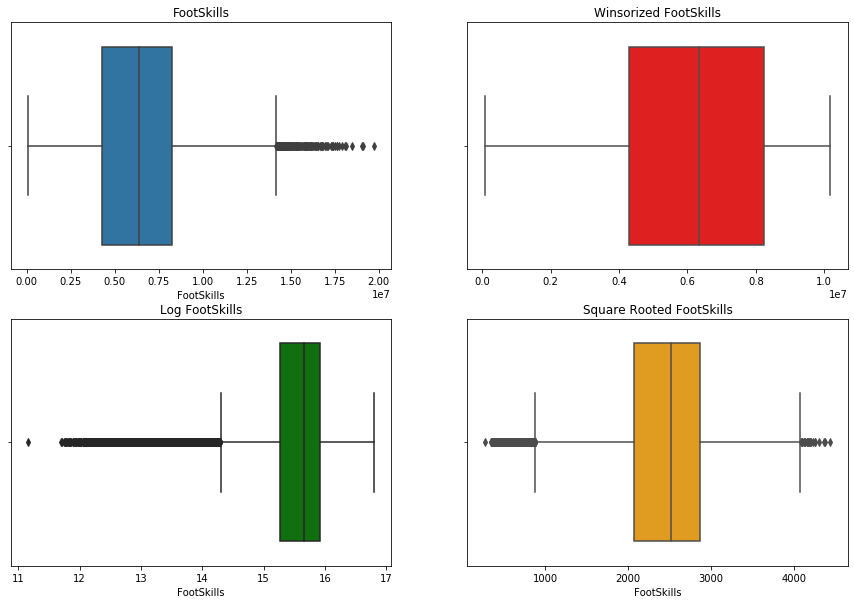

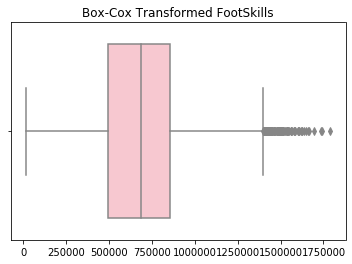

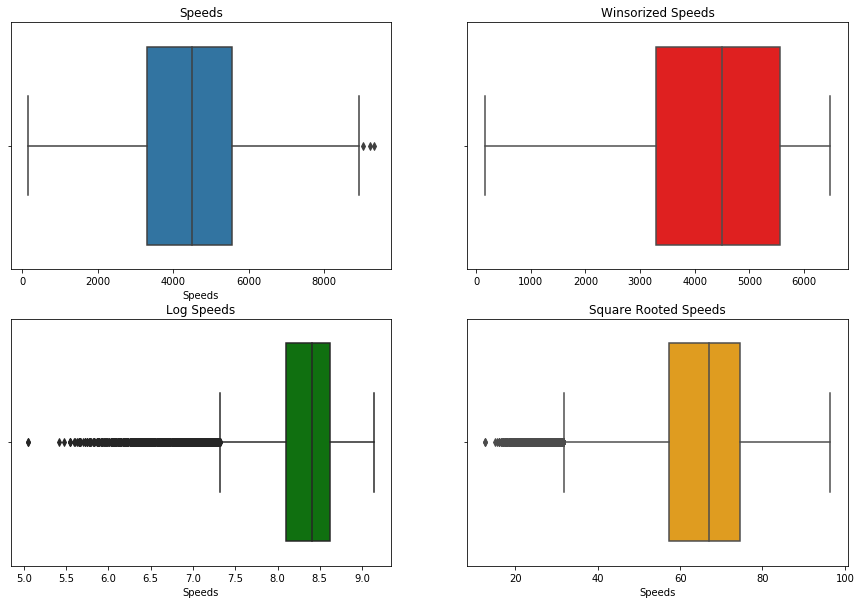

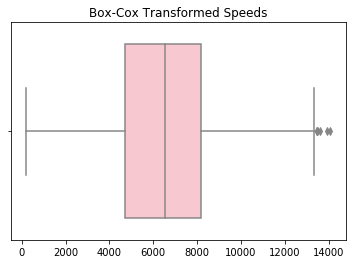

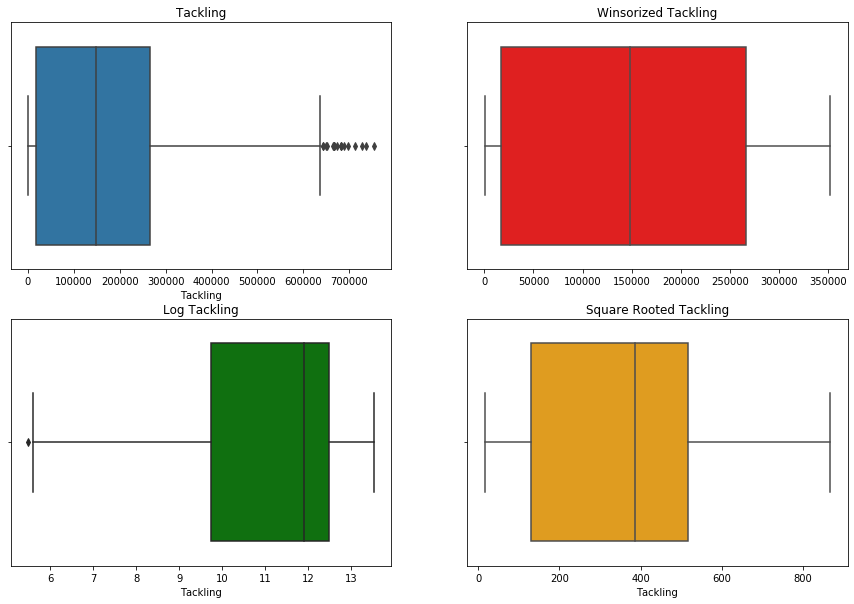

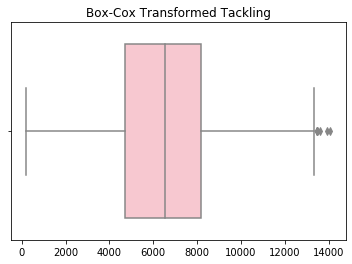

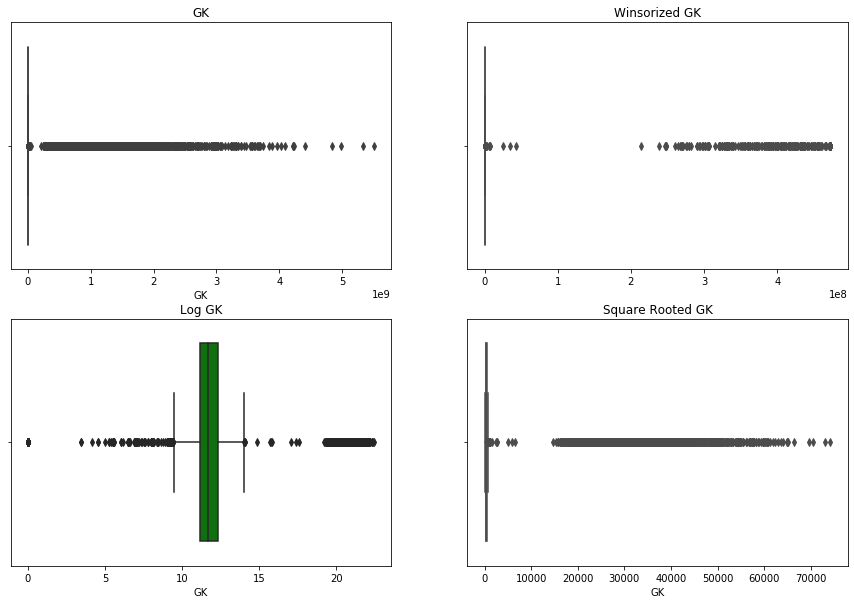

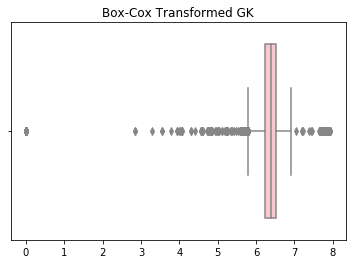

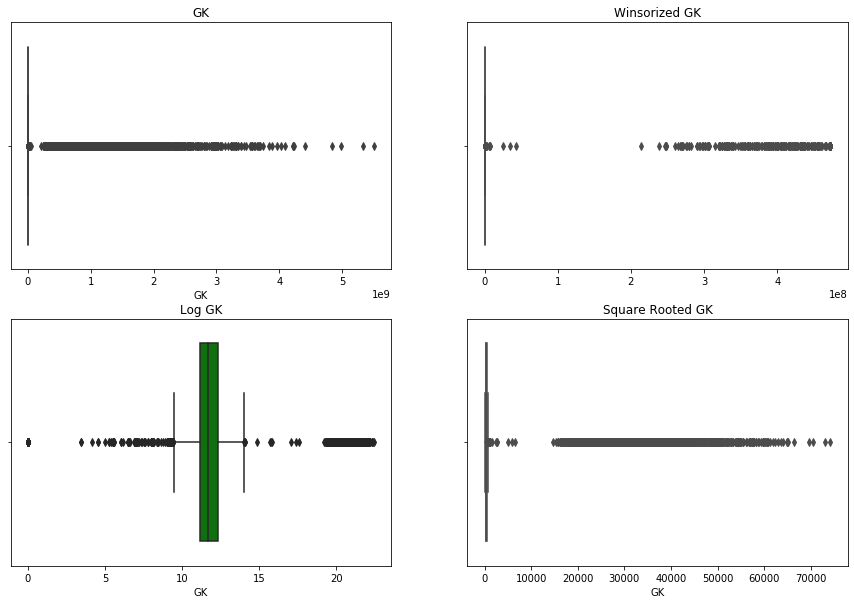

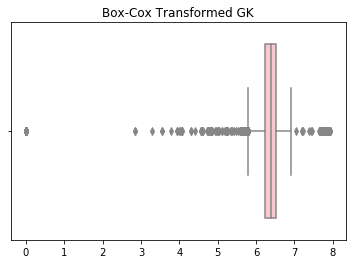

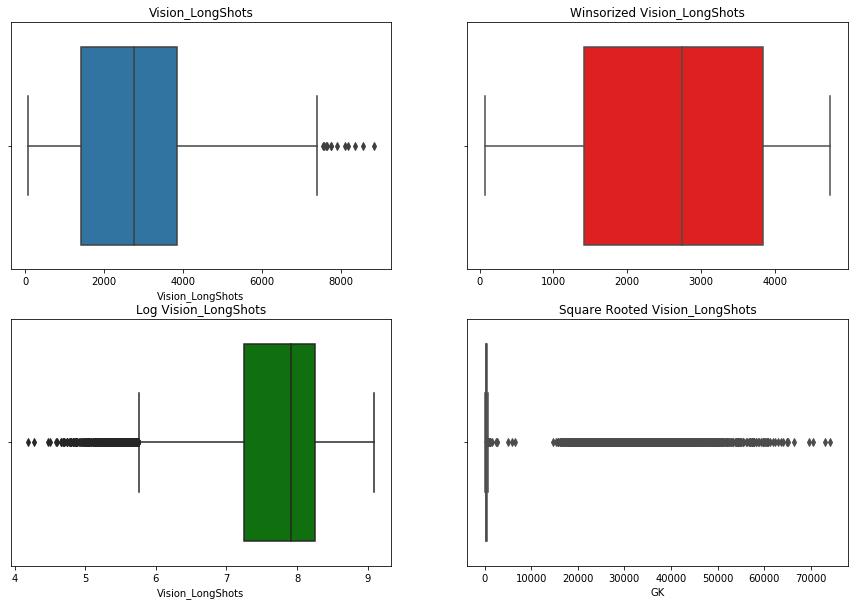

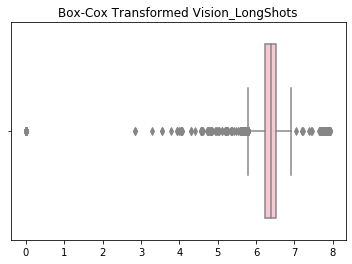

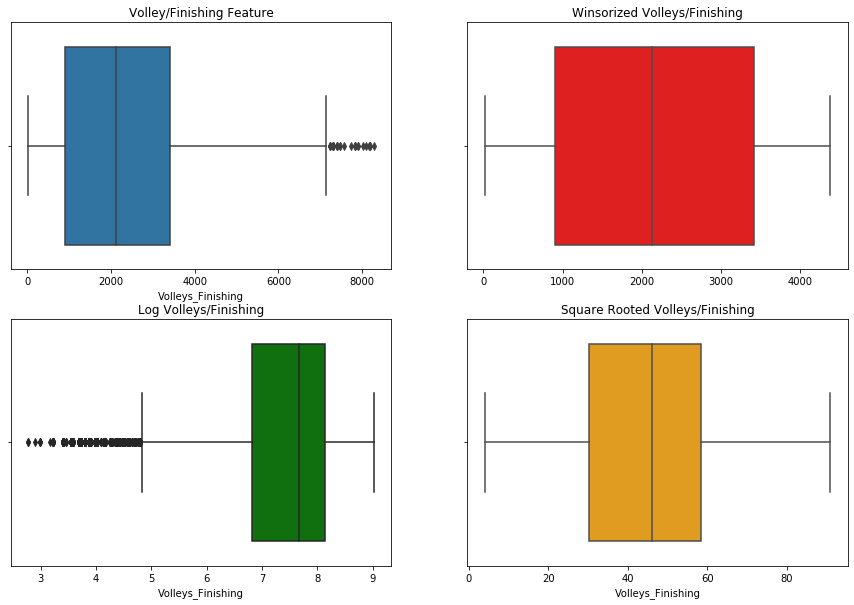

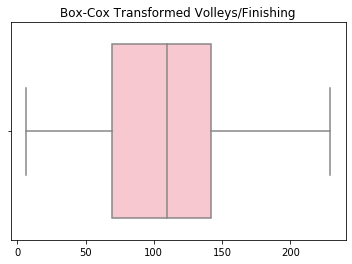

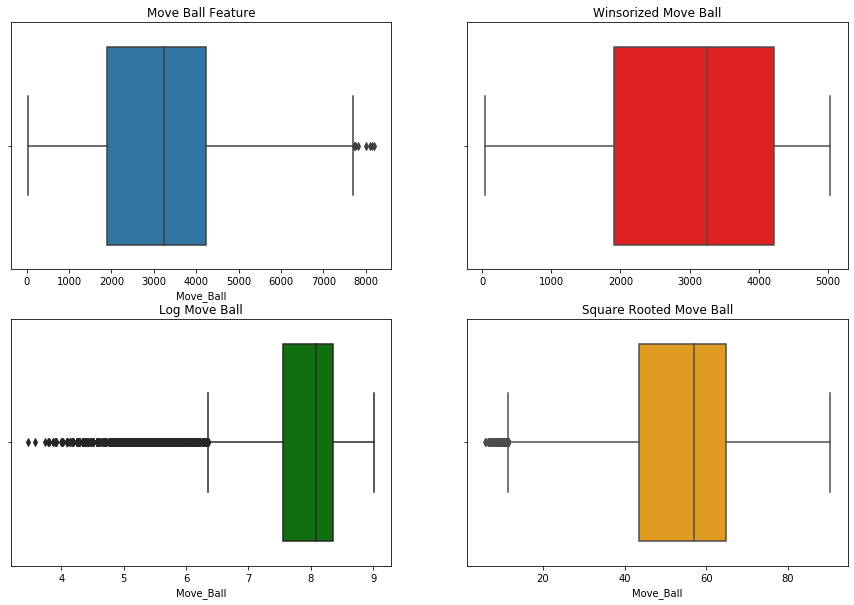

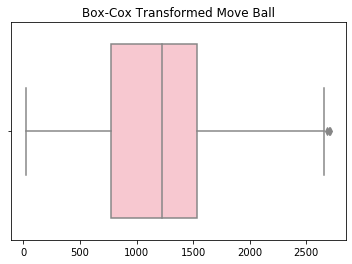

In [98]:
# Visualizing the distribution of our features
plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='FootSkills', data=fifa)
plt.title('FootSkills')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_FootSkills, color='red')
plt.title('Winsorized FootSkills')
plt.subplot(2, 2, 3)
sns.boxplot(log_FootSkills, color='green')
plt.title('Log FootSkills')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_FootSkills, color='orange')
plt.title('Square Rooted FootSkills')
plt.show()
sns.boxplot(bc_FootSkills, color='pink')
plt.title('Box-Cox Transformed FootSkills')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='Speeds', data=fifa)
plt.title('Speeds')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_Speeds, color='red')
plt.title('Winsorized Speeds')
plt.subplot(2, 2, 3)
sns.boxplot(log_Speeds, color='green')
plt.title('Log Speeds')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_Speeds, color='orange')
plt.title('Square Rooted Speeds')
plt.show()
sns.boxplot(bc_Speeds, color='pink')
plt.title('Box-Cox Transformed Speeds')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(fifa['Tackling'])
plt.title('Tackling')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_Tackling, color='red')
plt.title('Winsorized Tackling')
plt.subplot(2, 2, 3)
sns.boxplot(log_Tackling, color='green')
plt.title('Log Tackling')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_Tackling, color='orange')
plt.title('Square Rooted Tackling')
plt.show()
sns.boxplot(bc_Speeds, color='pink')
plt.title('Box-Cox Transformed Tackling')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(fifa['GK'])
plt.title('GK')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_GK, color='red')
plt.title('Winsorized GK')
plt.subplot(2, 2, 3)
sns.boxplot(log_GK, color='green')
plt.title('Log GK')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_GK, color='orange')
plt.title('Square Rooted GK')
plt.show()
sns.boxplot(bc_GK, color='pink')
plt.title('Box-Cox Transformed GK')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(fifa['GK'])
plt.title('GK')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_GK, color='red')
plt.title('Winsorized GK')
plt.subplot(2, 2, 3)
sns.boxplot(log_GK, color='green')
plt.title('Log GK')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_GK, color='orange')
plt.title('Square Rooted GK')
plt.show()
sns.boxplot(bc_GK, color='pink')
plt.title('Box-Cox Transformed GK')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(fifa['Vision_LongShots'])
plt.title('Vision_LongShots')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_Vision_LongShots, color='red')
plt.title('Winsorized Vision_LongShots')
plt.subplot(2, 2, 3)
sns.boxplot(log_Vision_LongShots, color='green')
plt.title('Log Vision_LongShots')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_GK, color='orange')
plt.title('Square Rooted Vision_LongShots')
plt.show()
sns.boxplot(bc_GK, color='pink')
plt.title('Box-Cox Transformed Vision_LongShots')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(fifa['Volleys_Finishing'])
plt.title('Volley/Finishing Feature')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_Volleys_Finishing, color='red')
plt.title('Winsorized Volleys/Finishing')
plt.subplot(2, 2, 3)
sns.boxplot(log_Volleys_Finishing, color='green')
plt.title('Log Volleys/Finishing')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_Volleys_Finishing, color='orange')
plt.title('Square Rooted Volleys/Finishing')
plt.show()
sns.boxplot(bc_Volleys_Finishing, color='pink')
plt.title('Box-Cox Transformed Volleys/Finishing')
plt.show()

plt.figure(figsize = (15,10))
plt.subplot(2, 2, 1)
sns.boxplot(fifa['Move_Ball'])
plt.title('Move Ball Feature')
plt.subplot(2, 2, 2)
sns.boxplot(winsorized_Move_Ball, color='red')
plt.title('Winsorized Move Ball')
plt.subplot(2, 2, 3)
sns.boxplot(log_Move_Ball, color='green')
plt.title('Log Move Ball')
plt.subplot(2, 2, 4)
sns.boxplot(sqrt_Move_Ball, color='orange')
plt.title('Square Rooted Move Ball')
plt.show()
sns.boxplot(bc_Move_Ball, color='pink')
plt.title('Box-Cox Transformed Move Ball')
plt.show()

## Second Model

I've transformed and added about 15 new variables. While there is some improvement (fewer negative scores), this model still is no good.

In [60]:
rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = fifa['norm_sqrt_Wage']
X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions", 
          "norm_winsorized_Composure", 'norm_sqrt_International_Reputation', 'FootSkills', 'Speeds', 'Tackling', 
          'GK', 'Overall_Reactions', 'Vision_LongShots', 'Volleys_Finishing', 'Move_Ball']]#, "norm_sqrt_Potential", "norm_sqrt_Value", "norm_International Reputation", "norm_winsorized_Overall", "norm_winsorized_Reactions", "norm_winsorized_Composure"]]
# X = pd.get_dummies(X)
# X = X.dropna(axis=1)

# rfr.fit(X, Y)
cross_val_score(rfr, X, Y, cv=10)

array([-0.25305253,  0.11677311,  0.11652234,  0.17989704,  0.05813385,
        0.10286376,  0.09149014,  0.07460999,  0.11401077, -0.36340439])

In [61]:
rfr = ensemble.RandomForestRegressor(n_estimators=100)
Y = fifa['norm_sqrt_Wage']
X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions", 
          "norm_winsorized_Composure", 'norm_sqrt_International_Reputation', "norm_winsorized_FootSKills",
          "norm_winsorized_Speeds", "norm_winsorized_Tackling", 'norm_bc_GK',  "norm_winsorized_Vision_LongShots",
          "norm_bc_Volleys_Finishing", 'norm_winsorized_Move_Ball']]


print(cross_val_score(rfr, X, Y, cv=10))
rfr.fit(X, Y)
print('\n', rfr.feature_importances_)

[-0.28159609  0.07270482  0.10248623  0.17227242  0.05106921  0.09297388
  0.075332    0.07234192  0.10524561 -0.05605497]

 [0.10298299 0.10696083 0.5724873  0.01618605 0.01559792 0.
 0.01598325 0.02850315 0.02653949 0.04030588 0.01689514 0.03817795
 0.01938005]


In [ ]:
corr_mat = np.abs((fifa.corr().loc[:, ['Wage']])).sort_values(by='Wage', ascending=False)
corr_mat[:20]

In [62]:
fifa['transformed_Special'] = normalize(winsorize(fifa['Special'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_Vision'] = normalize(winsorize(fifa['Vision'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_ShortPassing'] = normalize(winsorize(fifa['ShortPassing'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_BallControl'] = normalize(winsorize(fifa['BallControl'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_LongPassing'] = normalize(winsorize(fifa['LongPassing'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_Skill Moves'] = normalize(winsorize(fifa['Skill Moves'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_Curve'] = normalize(winsorize(fifa['Curve'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_ShotPower'] = normalize(winsorize(fifa['ShotPower'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_Volleys'] = normalize(winsorize(fifa['Volleys'], (0, 0.10)).reshape(1,-1)).reshape(-1,1) 
fifa['transformed_LongShots'] = normalize(winsorize(fifa['LongShots'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_Dribbling'] = normalize(winsorize(fifa['Dribbling'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_FKAccuracy'] = normalize(winsorize(fifa['FKAccuracy'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)
fifa['transformed_Crossing'] = normalize(winsorize(fifa['Crossing'], (0, 0.10)).reshape(1,-1)).reshape(-1,1)

I'm not really sure where to go from here. All of my models have been terrible, yet the variables I'm using are fairly highly correlated with the target variable. Is there something I'm not seeing? Am I using the model incorrectly?

In [63]:
rfr = ensemble.RandomForestRegressor(n_estimators=100)
Y = fifa['norm_sqrt_Wage']
X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions", 
          "norm_winsorized_Composure", 'norm_sqrt_International_Reputation', 'transformed_Special', 
          'transformed_Vision', 'transformed_ShortPassing', 'transformed_BallControl', 'transformed_LongPassing',
         'transformed_Skill Moves', 'transformed_Curve', 'transformed_ShotPower', 'transformed_Volleys', 
         'transformed_LongShots', 'transformed_Dribbling', 'transformed_FKAccuracy', 'transformed_Crossing']]


print(cross_val_score(rfr, X, Y, cv=10))
rfr.fit(X, Y)
print('\n', rfr.feature_importances_)

[-0.49671885  0.07580115  0.06980667  0.13089744  0.0126774   0.09011819
  0.08066372  0.05306066  0.116711   -0.05943501]

 [0.10899261 0.11412107 0.57268466 0.01569811 0.01462793 0.
 0.01352359 0.01287376 0.01032823 0.00869968 0.0162414  0.00129829
 0.01466665 0.01540859 0.01761954 0.01424967 0.0123323  0.0217297
 0.01490423]


I'm running these features through an OLS model just to see what happens.. While the OLS models show they're still pretty crappy, I don't feel that it's nearly as bad as the random forest model. 

In [72]:

X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions", 
          "norm_winsorized_Composure", 'norm_sqrt_International_Reputation', 'transformed_Special', 
          'transformed_Vision', 'transformed_ShortPassing', 'transformed_BallControl', 'transformed_LongPassing',
         'transformed_Skill Moves', 'transformed_Curve', 'transformed_ShotPower', 'transformed_Volleys', 
         'transformed_LongShots', 'transformed_Dribbling', 'transformed_FKAccuracy', 'transformed_Crossing']]
Y = fifa['norm_sqrt_Wage']
lrm = linear_model.LinearRegression()

lrm.fit(X,Y)
print("The number of observations in training set is {}".format(X.shape[0]))
print("The number of observations in test set is {}".format(X.shape[0]))
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
X_const = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X_const).fit()

# We print the summary results
print(results.summary())

The number of observations in training set is 18147
The number of observations in test set is 18147

Coefficients: 
 [ 3.96266530e+00  1.66222124e-01  2.07423313e+00  4.02440163e-01
  2.56013599e-01  3.33066907e-16 -2.01120705e-01  7.50086556e-02
 -2.41898619e-02 -2.13244869e-01  2.41851594e-02 -8.56245825e-02
  7.35786452e-02  1.04608742e-01  1.26234015e-01 -5.06818205e-02
 -2.21021435e-02 -9.93846557e-03  9.36965914e-02]

Intercept: 
 -0.04364667249270827
                            OLS Regression Results                            
Dep. Variable:         norm_sqrt_Wage   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     1133.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:59:32   Log-Likelihood:                 78491.
No. Observations:               18147   AIC:                    

In [74]:

X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions", 
          "norm_winsorized_Composure", 'norm_sqrt_International_Reputation', 'transformed_Special', 
          'transformed_Vision', 'transformed_BallControl',
         'transformed_Skill Moves', 'transformed_Curve', 'transformed_ShotPower', 'transformed_Volleys', 
         'transformed_LongShots', 'transformed_Crossing']]
Y = fifa['norm_sqrt_Wage']
lrm = linear_model.LinearRegression()

lrm.fit(X,Y)
print("The number of observations in training set is {}".format(X.shape[0]))
print("The number of observations in test set is {}".format(X.shape[0]))
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
X_const = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X_const).fit()

# We print the summary results
print(results.summary())

The number of observations in training set is 18147
The number of observations in test set is 18147

Coefficients: 
 [ 3.95320193e+00  1.66163263e-01  2.08366468e+00  4.00179049e-01
  2.58815126e-01  2.22044605e-16 -1.97230981e-01  7.61952205e-02
 -2.31290092e-01 -9.07651201e-02  6.92642114e-02  1.05491153e-01
  1.21249767e-01 -5.48007612e-02  9.07814358e-02]

Intercept: 
 -0.04364015517206378
                            OLS Regression Results                            
Dep. Variable:         norm_sqrt_Wage   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     1457.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:00:46   Log-Likelihood:                 78491.
No. Observations:               18147   AIC:                        -1.570e+05
Df Residuals:                   18132   BIC:      

In [76]:
X = fifa[["norm_sqrt_Potential", "norm_sqrt_Value",  "norm_winsorized_Overall", "norm_winsorized_Reactions", 
          "norm_winsorized_Composure", 'norm_sqrt_International_Reputation', "norm_winsorized_FootSKills",
          "norm_winsorized_Speeds", "norm_winsorized_Tackling", 'norm_bc_GK',  "norm_winsorized_Vision_LongShots",
          "norm_bc_Volleys_Finishing", 'norm_winsorized_Move_Ball']]
Y = fifa['norm_sqrt_Wage']
lrm = linear_model.LinearRegression()

lrm.fit(X,Y)
print("The number of observations in training set is {}".format(X.shape[0]))
print("The number of observations in test set is {}".format(X.shape[0]))
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
X_const = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X_const).fit()

# We print the summary results
print(results.summary())

The number of observations in training set is 18147
The number of observations in test set is 18147

Coefficients: 
 [ 3.96623319e+00  1.66399188e-01  1.94493145e+00  3.64922063e-01
  1.33591669e-01  4.44089210e-16  1.83550901e-02 -1.58592903e-01
  3.10084709e-02  2.72321188e-01 -6.65152789e-02  2.21834203e-01
  6.03702988e-02]

Intercept: 
 -0.04509419973674776
                            OLS Regression Results                            
Dep. Variable:         norm_sqrt_Wage   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1715.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:02:06   Log-Likelihood:                 78534.
No. Observations:               18147   AIC:                        -1.570e+05
Df Residuals:                   18134   BIC:                        -1.569e+05
Df 

In [64]:
no_wage = fifa.drop(columns=['Wage'])
X = no_wage

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
no_wage['pca_20'] = sklearn_pca.fit_transform(X)
#Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)
#variables = sklearn_pca.explained_variance_ratio

ValueError: could not convert string to float: 'Argentina'